Here I investigate the number of significant associations present across different patch sizes.

In [2]:
import os
import sys
sys.path = ['/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages'] + sys.path
GTEx_directory = '/hps/nobackup/research/stegle/users/willj/GTEx'
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
import h5py
from scipy.stats import pearsonr
import statsmodels.stats.multitest as smm
import seaborn

In [162]:
mean_features = {}
with h5py.File(GTEx_directory + '/data/intermediate/retrained_inceptionet_aggregations.hdf5','r') as f:
    expression = f['lung']['256']['expression'].value
    for s in ['128','256','512','1024','2048']:
        size_mean_features = f['lung'][s]['mean'].value
        mean_features[s] = size_mean_features
        
    expression_IDs = f['lung']['256']['expression_IDs'].value

import pickle; pickle.dump([expression, expression_IDs, mean_features], open(GTEx_directory + '/small_data/lung_mean_256_and_expression.py','wb'))

# Most features don't vary

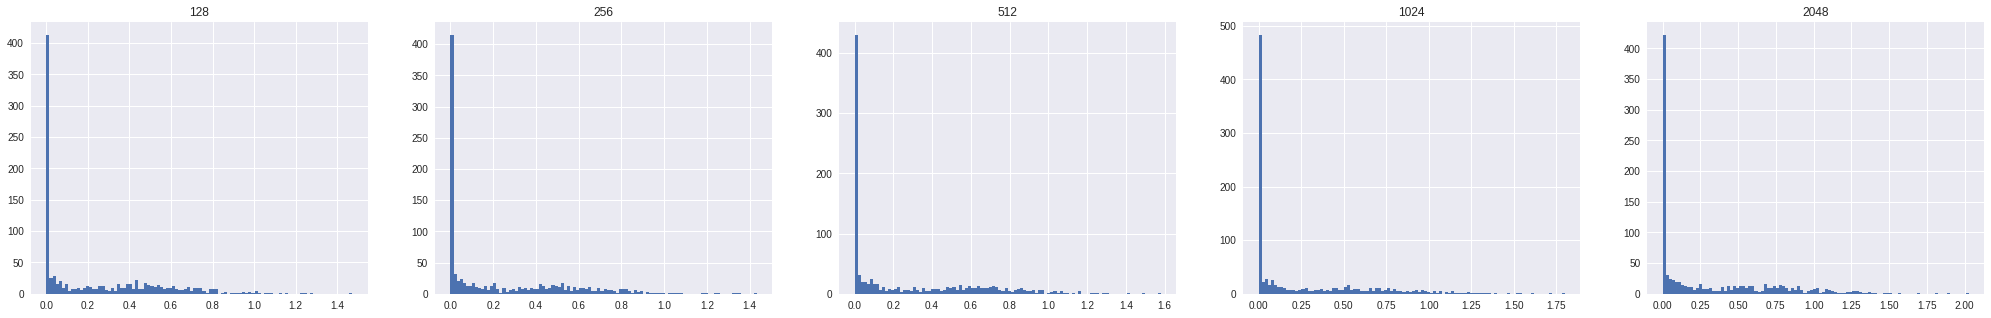

In [5]:
f, a = plt.subplots(1,5, figsize=(35,5))
for (i,s) in enumerate(['128','256','512','1024','2048']):
    a[i].hist(np.std(mean_features[s],axis=0),bins=100)
    a[i].set_title(s)
plt.show()

Which set of features shall we take that do not vary much across all patch sizes?

Even with feature concatenated across different patch sizes, the majority show low variation

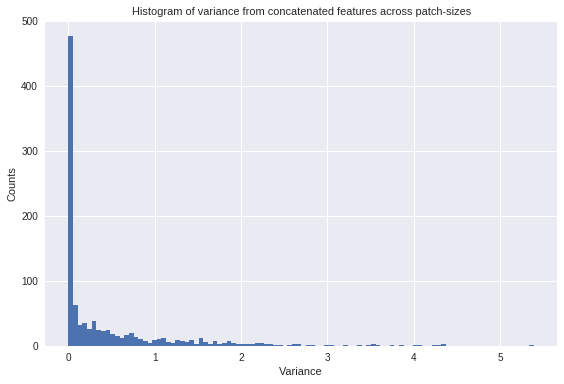

In [6]:
concatenated_features = np.vstack([mean_features['128'], mean_features['256'], mean_features['512'], mean_features['1024'], mean_features['2048']])
plt.hist(np.var(concatenated_features,axis=0),bins=100)
plt.title("Histogram of variance from concatenated features across patch-sizes",size=11)
plt.xlabel("Variance")
plt.ylabel("Counts")
plt.tight_layout()
plt.show()

# Most transcripts do not vary

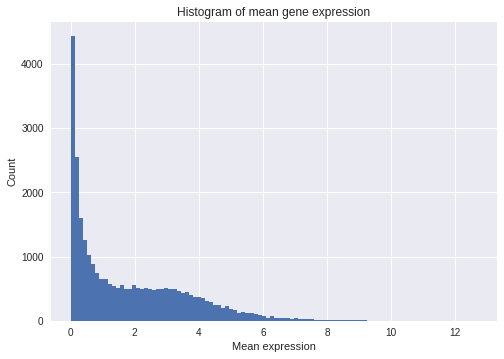

In [8]:
plt.hist(np.mean(expression,axis=0),bins=100)
plt.title("Histogram of mean gene expression")
plt.xlabel("Mean expression")
plt.ylabel("Count")
plt.show()

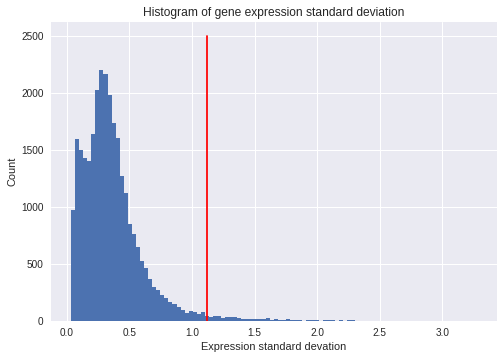

In [38]:
plt.hist(np.std(expression,axis=0),bins=100)
plt.plot([1.12, 1.12], [0, 2500],c='red')
plt.title("Histogram of gene expression standard deviation")
plt.xlabel("Expression standard devation")
plt.ylabel("Count")
plt.show()


## Choose 500 most varying features. Choose 500 most varying transcripts + 500 most expressed genes

In [28]:
min(np.mean(expression[:,np.argsort(np.mean(expression,axis=0))[-500:]],axis=0))

6.4467206

In [29]:
min(np.std(expression[:,np.argsort(np.std(expression,axis=0))[-500:]],axis=0))

1.1255841

In [10]:
most_expressed_transcript_idx = list(np.argsort(np.std(expression,axis=0))[-100:]) + list(np.argsort(np.mean(expression,axis=0))[-100:])
most_varying_feature_idx = np.argsort(np.std(concatenated_features,axis=0))[::-1][:100]

In [11]:
len(most_expressed_transcript_idx)

200

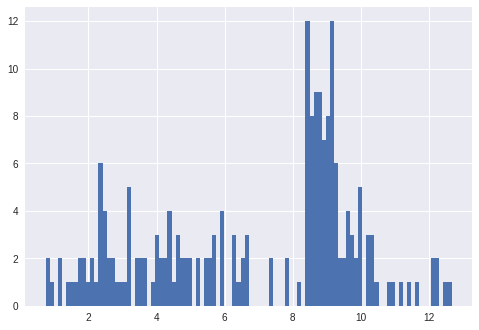

In [20]:
plt.hist(np.mean(expression,axis=0)[most_expressed_transcript_idx],bins=100)
plt.show()

In [16]:
print (min(np.std(expression,axis=0)[most_expressed_transcript_idx]))
print (min(np.mean(expression,axis=0)[most_expressed_transcript_idx]))
print (min(np.std(concatenated_features,axis=0)[most_varying_feature_idx]))

0.191119
0.744858
1.20242


Compare with the distriubtions above to see that much of the variation is caputured

# Raw number of associations for changing FDRs

# Compare across patch sizes and aggregations methods

In [9]:
import pdb

In [55]:
most_expressed_transcript_idx = list(np.argsort(np.std(expression,axis=0))[-100:]) + list(np.argsort(np.mean(expression,axis=0))[-100:])
most_varying_feature_idx = np.argsort(np.std(concatenated_features,axis=0))[::-1][:100]

results = {}
aggregations = ['mean','median']
sizes = ['128','256','512','1024','2048','4096']    
for a in aggregations:
    for s in sizes:
        print (a,s)
        with h5py.File(GTEx_directory + '/data/new_raw_inceptionet_aggregations.hdf5','r') as f:
            expression = f['lung'][s]['expression'].value
            mean_features = f['lung'][s][a].value
            expression_IDs = f['lung'][s]['expression_IDs'].value
            filt_expression = expression[:,most_expressed_transcript_idx]
            most_expressed_feature_idx = np.argsort(np.std(mean_features,axis=0))[::-1]
            filt_mean_features = mean_features[:,most_varying_feature_idx]
            N = 100
            M = 200
            pvalues = np.zeros((N,M))
            R_matrix = np.zeros((N,M))
            for i in range(N):
                if i%10 == 0:
                    print (i)
                for j in range(M):
                    res = pearsonr(filt_expression[:,j], filt_mean_features[:,i])
                    R_matrix[i,j] = res[0]
                    pvalues[i,j] = res[1]
            
            R_key = '{}_{}_{}'.format(a,s,'R')
            pvalue_key = '{}_{}_{}'.format(a,s,'pvalues')
            results[R_key] = R_matrix
            results[pvalue_key] = pvalues
            

import pickle; pickle.dump([most_expressed_transcript_idx, most_varying_feature_idx, results], open(GTEx_directory + '/data/quick_pvalues.py','wb'))

mean 128
0


/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/scipy/stats/stats.py:3021: RuntimeWarning: invalid value encountered in float_scalars
  r = r_num / r_den


10
20
30
40
50
60
70
80
90
mean 256
0
10
20
30
40
50
60
70
80
90
mean 512
0
10
20
30
40
50
60
70
80
90
mean 1024
0
10
20
30
40
50
60
70
80
90
mean 2048
0
10
20
30
40
50
60
70
80
90
mean 4096
0
10
20
30
40
50
60
70
80
90
median 128
0
10
20
30
40
50
60
70
80
90
median 256
0
10
20
30
40
50
60
70
80
90
median 512
0
10
20
30
40
50
60
70
80
90
median 1024
0
10
20
30
40
50
60
70
80
90
median 2048
0
10
20
30
40
50
60
70
80
90
median 4096
0
10
20
30
40
50
60
70
80
90


In [56]:
import pickle; pickle.dump([most_expressed_transcript_idx, most_varying_feature_idx, results], open(GTEx_directory + '/data/quick_pvalues.py','wb'))

In [86]:
import pickle; [most_expressed_transcript_idx, most_varying_feature_idx, results] = pickle.load(open(GTEx_directory + '/data/quick_pvalues.py','rb'))

# Plot raw number of associations as a function of aggregation method and patch size

## There seems to be a maximum at patch size 256

In [88]:
alphas = [0.0001,0.00001,0.000001,0.0000001,0.00000001,0.000000001,0.0000000001]
sizes = [128,256,512,1024,2048,4096]
aggregations = ['mean','median']

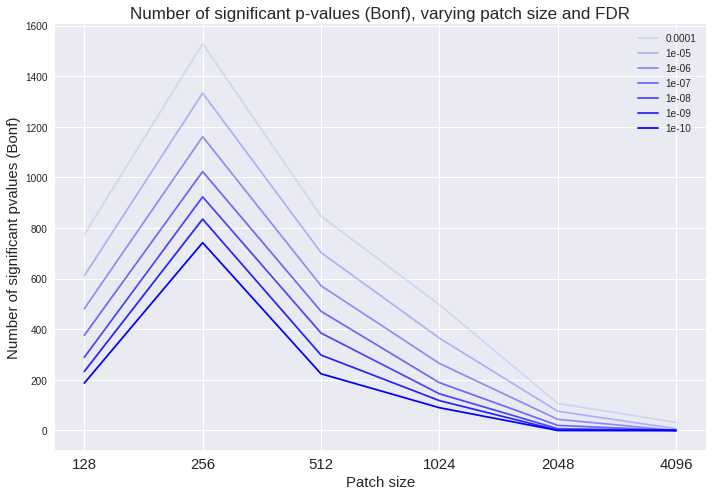

In [100]:
plt.figure(figsize=(10,7))
plt.title("Number of significant p-values (Bonf), varying patch size and FDR", size=17)
plt.xticks(range(len(alphas)),sizes,size=15)
plt.xlabel('Patch size',size=15)
plt.ylabel('Number of significant pvalues (Bonf)',size=15)
for a in aggregations[0:1]:
    for (k, alph) in enumerate(alphas):
        points = [sum(smm.multipletests(results['{}_{}_{}'.format(a,s,'pvalues')].flatten(),method='bonferroni',alpha=alph)[0]) for s in sizes]
        plt.plot(points, c='blue',label=alph, alpha=0.1+0.15*k)
plt.legend()
plt.tight_layout()

# Comparing mean / median

## More associations using mean apart from at very large patch sizes.

mean_128_pvalues
mean_256_pvalues
mean_512_pvalues
mean_1024_pvalues
mean_2048_pvalues
mean_4096_pvalues
median_128_pvalues
median_256_pvalues
median_512_pvalues
median_1024_pvalues
median_2048_pvalues
median_4096_pvalues


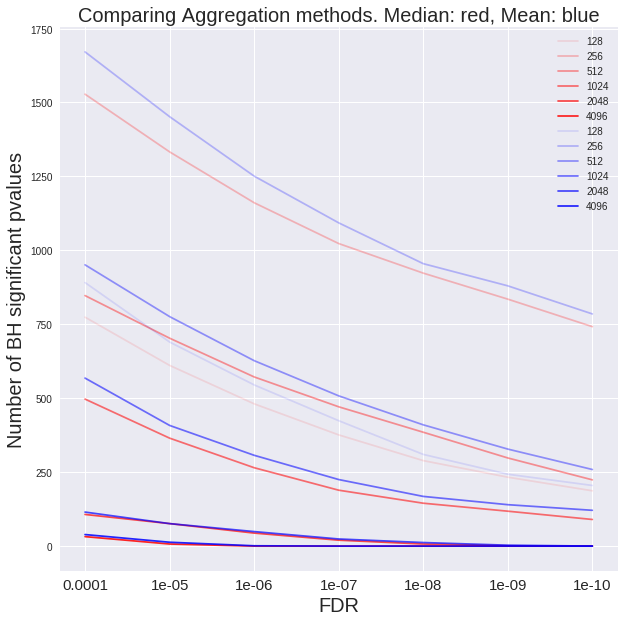

In [95]:

plt.figure(figsize=(10,10))
plt.title("Comparing Aggregation methods. Median: red, Mean: blue",size=20)
plt.xticks(range(len(alphas)),alphas,size=15)
plt.xlabel('FDR',size=20)
plt.ylabel('Number of BH significant pvalues',size=20)
for a in aggregations:
    for (k,s) in enumerate(sizes):
        if a == 'mean':
            c = 'red'
        else:
            c = 'blue'
            
        assoc_key = '{}_{}_{}'.format(a,s,'pvalues')
        print (assoc_key)
        associations = results[assoc_key]
        
        points = [sum(smm.multipletests(associations.flatten(),method='bonferroni',alpha=a)[0]) for a in alphas]
        plt.plot(points, c=c,label=s,alpha=0.1 + 0.15*k)
plt.legend()

        

# Number of features that have significant associations - to account for SNPs in LD

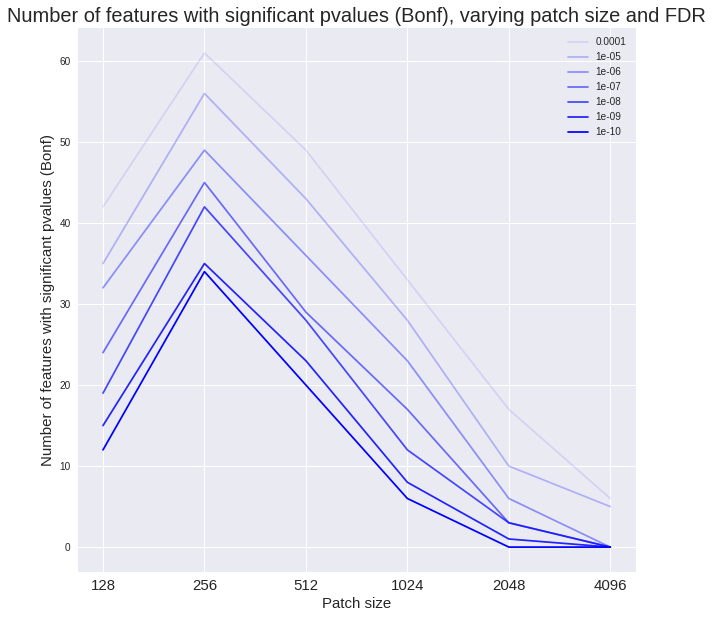

In [93]:
alphas = [0.0001,0.00001,0.000001,0.0000001,0.00000001,0.000000001,0.0000000001]
sizes = [128,256,512,1024,2048,4096]
aggregations = ['mean','median']
plt.figure(figsize=(10,10))
plt.title("Number of features with significant pvalues (Bonf), varying patch size and FDR", size=20)
plt.xticks(range(len(alphas)),sizes,size=15)
plt.xlabel('Patch size',size=15)
plt.ylabel('Number of features with significant pvalues (Bonf)',size=15)
for a in aggregations[0:1]:
    for (k, alph) in enumerate(alphas):
        points = [sum(np.sum(smm.multipletests(results['{}_{}_{}'.format(a,s,'pvalues')].flatten(),method='bonferroni',alpha=alph)[0].reshape(results['{}_{}_{}'.format(a,s,'R')].shape),axis=1) > 0) for s in sizes]
        plt.plot(points, c='blue',label=alph, alpha=0.1+0.15*k)
plt.legend()

# Number of transcripts that have significant associations to at least 1 feature

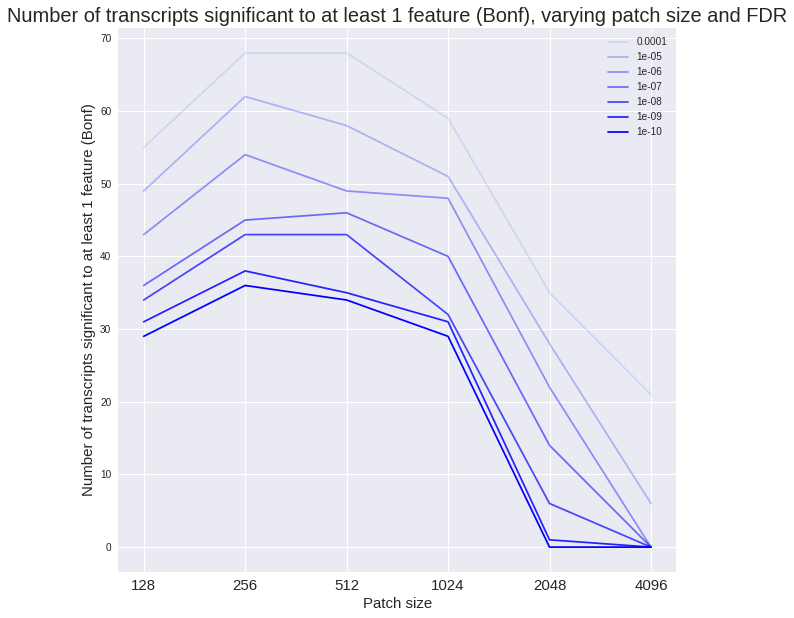

In [94]:
plt.figure(figsize=(10,10))
plt.title("Number of transcripts significant to at least 1 feature (Bonf), varying patch size and FDR", size=20)
plt.xticks(range(len(alphas)),sizes,size=15)
plt.xlabel('Patch size',size=15)
plt.ylabel('Number of transcripts significant to at least 1 feature (Bonf)',size=15)
for a in aggregations[0:1]:
    for (k, alph) in enumerate(alphas):
        points = [sum(np.sum(smm.multipletests(results['{}_{}_{}'.format(a,s,'pvalues')].flatten(),method='bonferroni',alpha=alph)[0].reshape(results['{}_{}_{}'.format(a,s,'R')].shape),axis=0) > 0) for s in sizes]
#         points = [sum(smm.multipletests(results['{}_{}_{}'.format(a,s,'R')].flatten(),method='bonferroni',alpha=alph)[0]) for s in sizes]
        plt.plot(points, c='blue',label=alph, alpha=0.1+0.15*k)
plt.legend()

In [40]:
import glob

In [149]:
def count_by_layer(tissue, size):
    layers = [1,7,12,65,166]
    raw_counts_re = '/data/features/{tissue}/raw*_{size}_*l{layer}_*'
    raw_counts = [len(glob.glob(GTEx_directory + raw_counts_re.format(tissue=tissue,size=size,layer=layer))) for layer in layers]
    raw_counts.append(len(glob.glob(GTEx_directory + '/data/features/{tissue}/raw*_{size}_*l-1.*'.format(tissue=tissue,size=size))))

    retrained_counts_re = '/data/features/{tissue}/retrained*_{size}_*l{layer}_*'
    retrained_counts_re = retrained_counts_re
    retrained_counts = [len(glob.glob(GTEx_directory + retrained_counts_re.format(tissue=tissue,size=size,layer=layer))) for layer in layers]
    retrained_counts.append(len(glob.glob(GTEx_directory + '/data/features/{tissue}/retrained*_{size}_*l-1.*'.format(tissue=tissue,size=size))))
#     print ('\t'.join([str(x) for x in raw_counts]))
    print ('Layer \t\t' + '\t'.join([str(x) for x in layers]) + '\t' + '-1')
    print ('Raw' + '\t\t' + '\t'.join([str(x) for x in raw_counts]))
    print ('Retrain' + '\t\t' + '\t'.join([str(x) for x in raw_counts]))
#     print ('Raw' + '\t\t' + '\t' + '\t'.join(retrained_counts))

    return raw_counts, retrained_counts

In [157]:
count_by_layer('Stomach',256)


Layer 		1	7	12	65	166	-1
Raw		338	338	338	338	338	169
Retrain		338	338	338	338	338	169


([338, 338, 338, 338, 338, 169], [338, 338, 338, 338, 338, 169])

In [73]:
glob.glob(GTEx_directory + '/data/features/Lung/*_256_*l{layer}*'.format(layer=1))

['/hps/nobackup/research/stegle/users/willj/GTEx/data/features/Lung/retrained_GTEX-12KS4-0726_256_l12_ca-max.hdf5',
 '/hps/nobackup/research/stegle/users/willj/GTEx/data/features/Lung/retrained_GTEX-139T6-0426_256_l166_ca-max.hdf5',
 '/hps/nobackup/research/stegle/users/willj/GTEx/data/features/Lung/retrained_GTEX-12WSG-0326_256_l12_ca-max.hdf5',
 '/hps/nobackup/research/stegle/users/willj/GTEx/data/features/Lung/retrained_GTEX-WFON-0426_256_l1_ca-max.hdf5',
 '/hps/nobackup/research/stegle/users/willj/GTEx/data/features/Lung/retrained_GTEX-11TUW-0526_256_l12_ca-max.hdf5',
 '/hps/nobackup/research/stegle/users/willj/GTEx/data/features/Lung/retrained_GTEX-ZLWG-0626_256_l166_ca-max.hdf5',
 '/hps/nobackup/research/stegle/users/willj/GTEx/data/features/Lung/retrained_GTEX-11ZTT-0626_256_l12_ca-max.hdf5',
 '/hps/nobackup/research/stegle/users/willj/GTEx/data/features/Lung/raw_GTEX-XXEK-0626_256_l1_ca-mean.hdf5',
 '/hps/nobackup/research/stegle/users/willj/GTEx/data/features/Lung/raw_GTEX-ZT9

In [70]:

count_by_layer('Lung',256)

[3864, 1288, 1288, 1288, 1288, 644]